# Identifikácia phishingových webových stránok pomocou ML

**Meno**: Bc. Tomáš Brček \
**Škola**: Slovenská technická univerzita v Bratislave \
**Fakulta**: Fakulta informatiky a informačných technológií \
**Rok**: 2025/2026

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer  
from sklearn.preprocessing import RobustScaler, FunctionTransformer
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score
from utils import add_missing_flags

## Load datasets

In [2]:
df_legitimate = pd.read_csv("dataset/new_datasets/df_benign.csv")
print("Legitimate URLs:", df_legitimate.shape)
df_legitimate.head()

Legitimate URLs: (10000, 25)


,phishing,url,url_len,host_len,path_len,query_len,is_https,count_dots,count_hyphen,count_at,...,has_ip,has_shortener,has_keyword,subdomain_len,domain,suffix,domain_entropy,domain_age,days_to_expire,registration_length
0,0,https://www.reelclassics.com/Actresses/Wyman/w...,54,20,26,0,1,2,0,0,...,0,0,0,0,www.reelclassics.com,com,3.308695,9910,1776,11687
1,0,https://www.nopainnogainmovie.com/home/,39,25,6,0,1,2,0,0,...,0,0,0,0,www.nopainnogainmovie.com,com,3.383465,7701,333,8035
2,0,https://www.idioms.thefreedictionary.com/stick...,64,32,24,0,1,3,0,0,...,0,0,1,0,www.idioms.thefreedictionary.com,com,3.843139,8163,3159,11323
3,0,https://www.people.famouswhy.com/terri_clark/,45,24,13,0,1,3,0,0,...,0,0,0,0,www.people.famouswhy.com,com,3.605389,7143,161,7304
4,0,https://www.twitter.com/HMSHost,31,15,8,0,1,2,0,0,...,0,0,0,0,www.twitter.com,com,2.923231,9394,102,9497


In [3]:
df_phishing = pd.read_csv("dataset/new_datasets/df_phishing.csv")
print("Phishing URLs:", df_phishing.shape)
df_phishing.head()

Phishing URLs: (10000, 25)


,phishing,url,url_len,host_len,path_len,query_len,is_https,count_dots,count_hyphen,count_at,...,has_ip,has_shortener,has_keyword,subdomain_len,domain,suffix,domain_entropy,domain_age,days_to_expire,registration_length
0,1,http://ca24148.tw1.ru/web/depart.php,36,14,15,0,0,2,0,0,...,0,0,0,0,ca24148.tw1.ru,ru,3.378783,7043,261,7305
1,1,https://transportedigno.cl/inoo/,32,18,6,0,1,1,0,0,...,0,0,0,0,transportedigno.cl,cl,3.725481,508,221,730
2,1,https://2bcapital.online,24,16,0,0,1,1,0,0,...,0,0,0,0,2bcapital.online,online,3.500000,36,328,365
3,1,https://att-service-104735.square.site/,39,30,1,0,1,2,2,0,...,0,0,0,0,att-service-104735.square.site,site,3.989898,2439,-1,-1
4,1,https://kyukjhjhterryuy.com/?tid=r16ZF3,39,19,1,10,1,1,0,0,...,0,0,0,0,kyukjhjhterryuy.com,com,3.471354,15,349,365


In [4]:
df_all = pd.concat([df_legitimate, df_phishing], ignore_index=True)
print("All URLs:", df_all.shape)
df_all.head()

All URLs: (20000, 25)


,phishing,url,url_len,host_len,path_len,query_len,is_https,count_dots,count_hyphen,count_at,...,has_ip,has_shortener,has_keyword,subdomain_len,domain,suffix,domain_entropy,domain_age,days_to_expire,registration_length
0,0,https://www.reelclassics.com/Actresses/Wyman/w...,54,20,26,0,1,2,0,0,...,0,0,0,0,www.reelclassics.com,com,3.308695,9910,1776,11687
1,0,https://www.nopainnogainmovie.com/home/,39,25,6,0,1,2,0,0,...,0,0,0,0,www.nopainnogainmovie.com,com,3.383465,7701,333,8035
2,0,https://www.idioms.thefreedictionary.com/stick...,64,32,24,0,1,3,0,0,...,0,0,1,0,www.idioms.thefreedictionary.com,com,3.843139,8163,3159,11323
3,0,https://www.people.famouswhy.com/terri_clark/,45,24,13,0,1,3,0,0,...,0,0,0,0,www.people.famouswhy.com,com,3.605389,7143,161,7304
4,0,https://www.twitter.com/HMSHost,31,15,8,0,1,2,0,0,...,0,0,0,0,www.twitter.com,com,2.923231,9394,102,9497


In [5]:
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
df_all.replace(-1, pd.NA, inplace=True)

df_all["domain_age"] = pd.to_numeric(df_all["domain_age"], errors='coerce').astype("Int64")
df_all["days_to_expire"] = pd.to_numeric(df_all["days_to_expire"], errors='coerce').astype("Int64")
df_all["registration_length"] = pd.to_numeric(df_all["registration_length"], errors='coerce').astype("Int64")

df_all.head()

,phishing,url,url_len,host_len,path_len,query_len,is_https,count_dots,count_hyphen,count_at,...,has_ip,has_shortener,has_keyword,subdomain_len,domain,suffix,domain_entropy,domain_age,days_to_expire,registration_length
0,1,https://ipfs.io/ipfs/QmXiXAhetvCunzxiBbWPLQNVU...,67,7,52,0,1,1,0,0,...,0,0,0,0,ipfs.io,io,2.521641,4165,217,4383
1,0,https://www.movies.rediff.com/slide-show/2009/...,100,21,71,0,1,3,9,0,...,0,0,0,0,www.movies.rediff.com,com,3.463281,10472,3042,13515
2,0,https://www.comfibook.com/n/Jen+Chien,37,17,12,0,1,2,0,0,...,0,0,0,0,www.comfibook.com,com,2.984234,5883,325,6209
3,0,https://www.ramsgab.com/2011/04/19/2011-st-lou...,136,15,113,0,1,2,14,0,...,0,0,0,0,www.ramsgab.com,com,3.189898,6696,243,6940
4,1,http://sac-terra.paginas.site/,30,22,1,0,0,2,1,0,...,0,0,0,0,sac-terra.paginas.site,site,3.425119,3173,113,3287


## EDA

In [6]:
df_all.dtypes

phishing                 int64
url                     object
url_len                  int64
host_len                 int64
path_len                 int64
query_len                int64
is_https                 int64
count_dots               int64
count_hyphen             int64
count_at                 int64
count_qm                 int64
count_eq                 int64
count_slash              int64
count_double_slash       int64
count_digits             int64
has_ip                   int64
has_shortener            int64
has_keyword              int64
subdomain_len            int64
domain                  object
suffix                  object
domain_entropy         float64
domain_age               Int64
days_to_expire           Int64
registration_length      Int64
dtype: object

In [7]:
df_all.isnull().sum()

phishing                  0
url                       0
url_len                   0
host_len                  0
path_len                  0
query_len                 0
is_https                  0
count_dots                0
count_hyphen              0
count_at                  0
count_qm                  0
count_eq                  0
count_slash               0
count_double_slash        0
count_digits              0
has_ip                    0
has_shortener             0
has_keyword               0
subdomain_len             0
domain                    6
suffix                    7
domain_entropy            0
domain_age             4720
days_to_expire         4776
registration_length    4777
dtype: int64

In [8]:
df_all.shape[0] - df_all.dropna().shape[0]

4778

In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   phishing             20000 non-null  int64  
 1   url                  20000 non-null  object 
 2   url_len              20000 non-null  int64  
 3   host_len             20000 non-null  int64  
 4   path_len             20000 non-null  int64  
 5   query_len            20000 non-null  int64  
 6   is_https             20000 non-null  int64  
 7   count_dots           20000 non-null  int64  
 8   count_hyphen         20000 non-null  int64  
 9   count_at             20000 non-null  int64  
 10  count_qm             20000 non-null  int64  
 11  count_eq             20000 non-null  int64  
 12  count_slash          20000 non-null  int64  
 13  count_double_slash   20000 non-null  int64  
 14  count_digits         20000 non-null  int64  
 15  has_ip               20000 non-null 

### Kategorické stĺpce

In [10]:
df_all.describe(exclude=np.number)

,url,domain,suffix
count,20000,19994,19993
unique,19931,12048,213
top,https://schweizerischepost.bumbleshrimp.com/,docs.google.com,com
freq,3,886,12004


In [11]:
for col in df_all.select_dtypes(exclude=['number']).columns:
    print(f"Value counts for column '{col}':")
    print(df_all[col].value_counts())
    print("\n")

Value counts for column 'url':
url
https://schweizerischepost.bumbleshrimp.com/                                                                                                                            3
https://ru.shardocs.com/800-441-7762/voicemail/ssoauth.php                                                                                                              3
https://mywinterhaven.shardocs.com/800-441-7762/voicemail/listen.php?c=amFkYW1zQG15d2ludGVyaGF2ZW4uY29t&organisation=mywinterhaven&=amFkYW1zQG15d2ludGVyaGF2ZW4uY29t    3
https://qib.shardocs.com/800-441-7762/voicemail/listen.php?c=cGFyYWcudGlrZWthckBxaWIuY29tLnFh&organisation=qib&=cGFyYWcudGlrZWthckBxaWIuY29tLnFh                        3
https://everyone-que-labs-galaxy.trycloudflare.com/login.html                                                                                                           3
                                                                                                                   

### Numerické stĺpce

In [12]:
df_all.describe()

,phishing,url_len,host_len,path_len,query_len,is_https,count_dots,count_hyphen,count_at,count_qm,...,count_double_slash,count_digits,has_ip,has_shortener,has_keyword,subdomain_len,domain_entropy,domain_age,days_to_expire,registration_length
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.000000,15280.0,15224.0,15223.0
mean,0.500000,58.700250,20.287400,23.264200,6.946450,0.915700,2.032600,1.203150,0.005450,0.149600,...,0.008250,4.806300,0.002450,0.022350,0.040600,0.0,3.398097,7066.199215,652.959932,7732.957367
std,0.500013,54.707292,9.689324,29.192715,43.278839,0.277844,0.601212,2.274256,0.074971,0.373265,...,0.115683,10.836187,0.049438,0.147823,0.197367,0.0,0.454074,3699.856272,819.727354,3898.47772
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,-1291.0,364.0
25%,0.000000,34.000000,15.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.121928,4679.0,168.0,5843.0
50%,0.500000,46.000000,19.000000,14.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,3.431519,7846.0,334.0,8766.0
75%,1.000000,67.000000,24.000000,32.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,6.000000,0.000000,0.000000,0.000000,0.0,3.708132,10253.0,852.75,10957.0
max,1.000000,3656.000000,92.000000,655.000000,3625.000000,1.000000,6.000000,41.000000,2.000000,4.000000,...,5.000000,643.000000,1.000000,1.000000,1.000000,0.0,4.909113,14780.0,30067.0,38350.0


In [13]:
for ds in [df_all]:
    for col in ds.select_dtypes(include=['number']).columns:
        mean_value = round(np.mean(ds[col]), 3)
        median_value = round(np.median(ds[col]), 3)
        mode_result = stats.mode(ds[col], nan_policy='omit')
        try:
            mode_value = mode_result.mode[0]
        except IndexError: 
            mode_value = None
        mode_display = mode_value if mode_value is not None else "N/A"
        print(f"{col:30} -> Mean: {mean_value:>8}, Median: {median_value:>8}, Mode: {mode_display:>8}")

phishing                       -> Mean:      0.5, Median:      0.5, Mode:      N/A
url_len                        -> Mean:     58.7, Median:     46.0, Mode:      N/A
host_len                       -> Mean:   20.287, Median:     19.0, Mode:      N/A
path_len                       -> Mean:   23.264, Median:     14.0, Mode:      N/A
query_len                      -> Mean:    6.946, Median:      0.0, Mode:      N/A
is_https                       -> Mean:    0.916, Median:      1.0, Mode:      N/A
count_dots                     -> Mean:    2.033, Median:      2.0, Mode:      N/A
count_hyphen                   -> Mean:    1.203, Median:      0.0, Mode:      N/A
count_at                       -> Mean:    0.005, Median:      0.0, Mode:      N/A
count_qm                       -> Mean:     0.15, Median:      0.0, Mode:      N/A
count_eq                       -> Mean:    0.333, Median:      0.0, Mode:      N/A
count_slash                    -> Mean:    4.011, Median:      3.0, Mode:      N/A
coun

In [14]:
def evaluate_skewness(skewness: float) -> str:
    if -0.5 <= skewness <= 0.5:
        return f"Slightly skewed to the {'left' if skewness > 0 else 'right'}"
    elif -1 < skewness < -0.5 or 0.5 < skewness < 1:
        return f"Moderately skewed to the {'left' if skewness > 0 else 'right'}"
    elif skewness <= -1 or skewness >= 1:
        return f"Highly skewed to the {'left' if skewness > 0 else 'right'}"
    else:
        return "Invalid value."

In [15]:
def evaluate_kurtosis(kurtosis: float) -> str:
    if kurtosis > 3:
        return "Kurtosis is high."
    elif kurtosis < 3:
        return "Kurtosis is low."

In [16]:
for col in df_all.select_dtypes(include=['number']).columns:
    skewness_value = round(stats.skew(df_all[col].dropna()), 3)
    kurtosis_value = round(stats.kurtosis(df_all[col].dropna()), 3)
    skewness_eval = evaluate_skewness(skewness_value)
    kurtosis_eval = evaluate_kurtosis(kurtosis_value)
    
    print(f"{col:27} Skewness: {skewness_value:>8} -> {skewness_eval:<30} Kurtosis: {kurtosis_value:>8} -> {kurtosis_eval}")

phishing                    Skewness:      0.0 -> Slightly skewed to the right   Kurtosis:     -2.0 -> Kurtosis is low.
url_len                     Skewness:   19.036 -> Highly skewed to the left      Kurtosis:  997.057 -> Kurtosis is high.
host_len                    Skewness:    1.824 -> Highly skewed to the left      Kurtosis:    6.568 -> Kurtosis is high.
path_len                    Skewness:    3.375 -> Highly skewed to the left      Kurtosis:   36.953 -> Kurtosis is high.
query_len                   Skewness:   37.369 -> Highly skewed to the left      Kurtosis: 2589.672 -> Kurtosis is high.
is_https                    Skewness:   -2.992 -> Highly skewed to the right     Kurtosis:    6.954 -> Kurtosis is high.
count_dots                  Skewness:    0.469 -> Slightly skewed to the left    Kurtosis:    1.672 -> Kurtosis is low.
count_hyphen                Skewness:    4.162 -> Highly skewed to the left      Kurtosis:   29.569 -> Kurtosis is high.
count_at                    Skewne

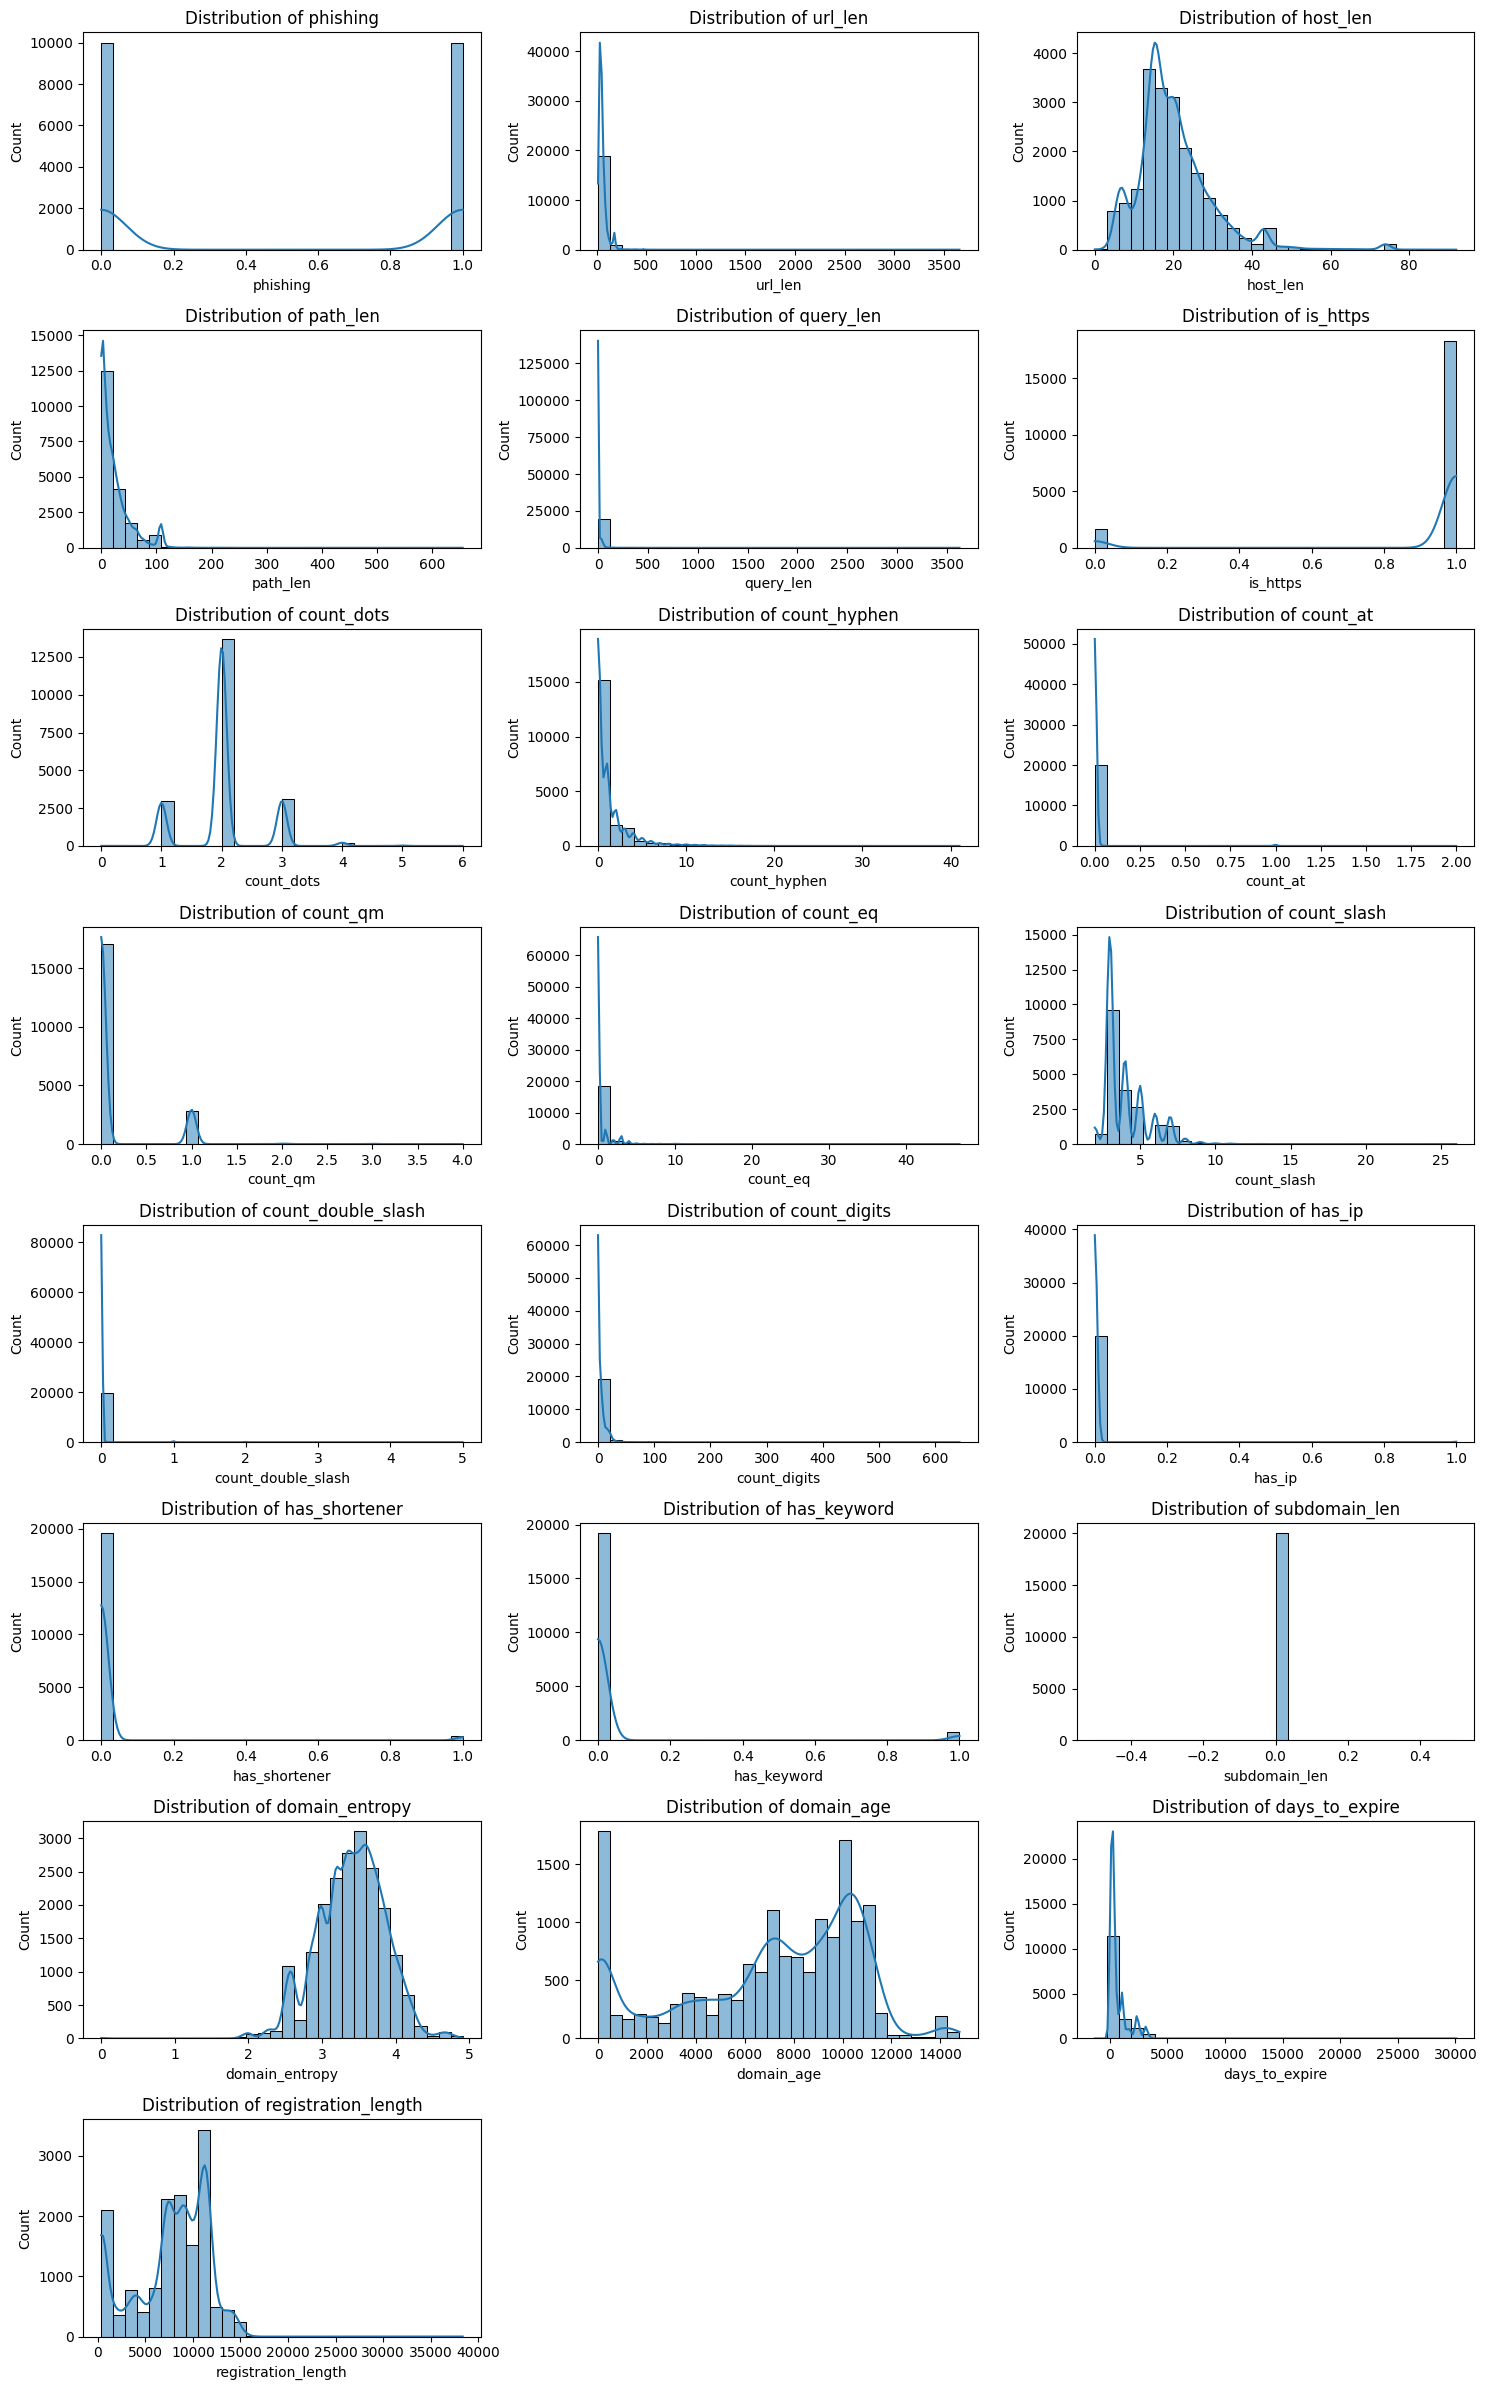

In [17]:
num_cols = 3
numeric_cols = df_all.select_dtypes(include=['number']).columns
num_plots = len(numeric_cols)

num_rows = (num_plots // num_cols) + (num_plots % num_cols > 0)

if num_rows > 0:
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

    if num_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(df_all[col], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_ylabel('Count')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

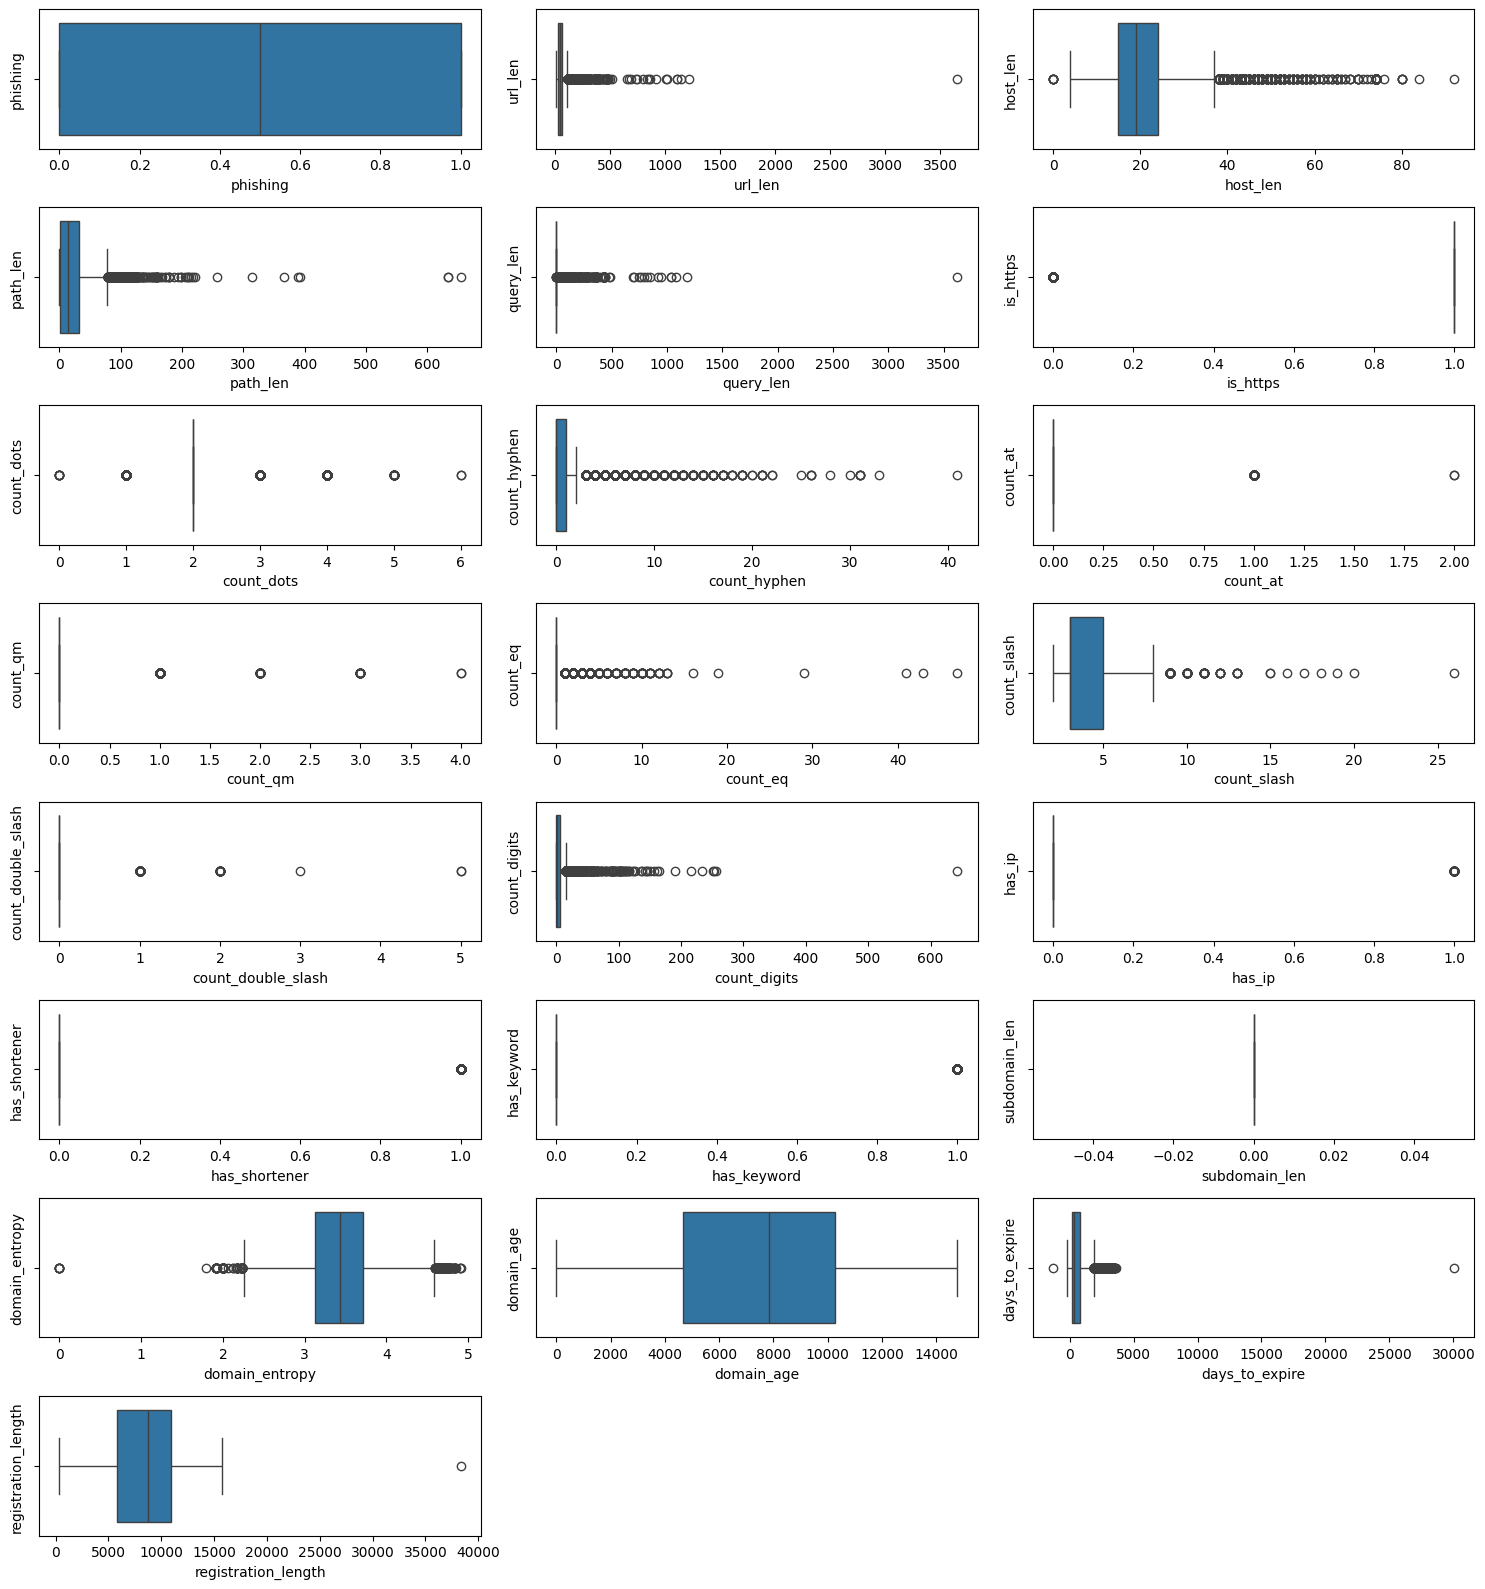

In [18]:
numeric_cols = df_all.select_dtypes(include=['number']).columns
num_plots = len(numeric_cols)

num_rows = (num_plots // num_cols) + (num_plots % num_cols > 0)

if num_rows > 0:
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 2))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=col, data=df_all, ax=axes[i])
        axes[i].set_ylabel(col)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Párová analýza

In [ ]:
num_cols = len(df_all.columns)
cols = 2
rows = (num_cols // cols) + (num_cols % cols > 0)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, rows * 5))
axes = axes.flatten()

for i, col in enumerate(df_all.drop(columns=["phishing", "domain", "url", "suffix"]).columns):
    sns.boxplot(x='phishing', y=col, data=df_all, ax=axes[i])
    axes[i].set_title(f'Boxplot for {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

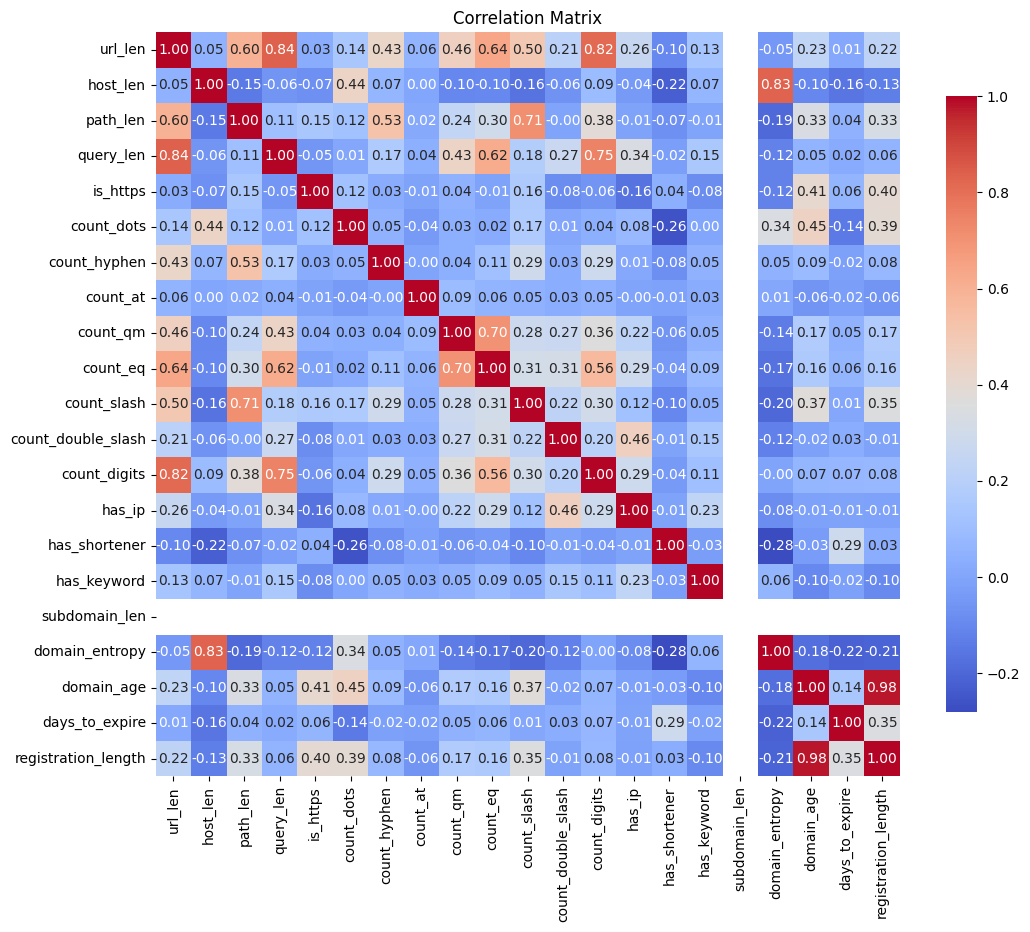

In [19]:
# correlation of each column with phishing column put into matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df_all.drop(columns=["phishing", "domain", "url", "suffix"]).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

### Odstránenie duplikátov

In [20]:
rows_duplicates = df_all[df_all.duplicated()]
len(rows_duplicates)

62

In [21]:
df_all.drop_duplicates(inplace=True)

In [22]:
columns_duplicates = df_all.T[df_all.T.duplicated()]
len(columns_duplicates)

0

In [23]:
for col in df_all.columns:
    print(f"{col:20}: {len(df_all[col].unique())}")

phishing            : 2
url                 : 19931
url_len             : 299
host_len            : 75
path_len            : 173
query_len           : 222
is_https            : 2
count_dots          : 7
count_hyphen        : 30
count_at            : 3
count_qm            : 5
count_eq            : 20
count_slash         : 19
count_double_slash  : 5
count_digits        : 114
has_ip              : 2
has_shortener       : 2
has_keyword         : 2
subdomain_len       : 1
domain              : 12049
suffix              : 214
domain_entropy      : 2385
domain_age          : 3953
days_to_expire      : 1337
registration_length : 570


In [24]:
df_all.isnull().sum()

phishing                  0
url                       0
url_len                   0
host_len                  0
path_len                  0
query_len                 0
is_https                  0
count_dots                0
count_hyphen              0
count_at                  0
count_qm                  0
count_eq                  0
count_slash               0
count_double_slash        0
count_digits              0
has_ip                    0
has_shortener             0
has_keyword               0
subdomain_len             0
domain                    6
suffix                    7
domain_entropy            0
domain_age             4702
days_to_expire         4758
registration_length    4759
dtype: int64

In [25]:
numeric_cols = df_all.select_dtypes(include=['number'])

Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)

IQR = Q3 - Q1

outliers = ((numeric_cols < (Q1 - 1.5 * IQR)) | 
            (numeric_cols > (Q3 + 1.5 * IQR)))

outliers_count = outliers.sum()

print(outliers_count)

phishing                  0
url_len                1496
host_len               1015
path_len               1193
query_len              2878
is_https               1671
count_dots             6293
count_hyphen           2936
count_at                107
count_qm               2889
count_eq               2807
count_slash             169
count_double_slash      126
count_digits           1774
has_ip                   49
has_shortener           447
has_keyword             806
subdomain_len             0
domain_entropy          278
domain_age                0
days_to_expire         1600
registration_length       1
dtype: Int64


## Príprava na trénovanie

In [26]:
train_df, test_df = train_test_split(df_all, test_size=0.25, random_state=42)
print(train_df.shape)
print(test_df.shape)

(14953, 25)
(4985, 25)


### Výber stĺpcov

In [30]:
"""
from sklearn.feature_selection import f_classif, SelectKBest

X = train_df.drop(columns="phishing")
y = train_df["phishing"]

anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(X, y)
anova_scores = anova_selector.scores_
selected_columns = X.columns
imp_columns = []

anova_features_scores = sorted(zip(selected_columns, anova_scores), key=lambda x: x[1], reverse=True)

for feature, score in anova_features_scores:
    print(f"Feature: {feature:28} Score: {score}")
    if score > 50:
        imp_columns.append(feature)
"""

'\nfrom sklearn.feature_selection import f_classif, SelectKBest\n\nX = train_df.drop(columns="phishing")\ny = train_df["phishing"]\n\nanova_selector = SelectKBest(score_func=f_classif, k=\'all\')\nanova_selector.fit(X, y)\nanova_scores = anova_selector.scores_\nselected_columns = X.columns\nimp_columns = []\n\nanova_features_scores = sorted(zip(selected_columns, anova_scores), key=lambda x: x[1], reverse=True)\n\nfor feature, score in anova_features_scores:\n    print(f"Feature: {feature:28} Score: {score}")\n    if score > 50:\n        imp_columns.append(feature)\n'

## Pipeline

### Testovanie rôznych modelov

In [ ]:
numeric_cols = ['domain_age', 'registration_length', 'domain_entropy', 'host_len', 'count_slash', 'subdomain_len', 'path_len', 'count_hyphen', 'domain_age', 'registration_length', 'days_to_expire', 'url_len', 'count_eq']
categorical_cols = ['suffix', 'domain']
binary_cols = ['is_https', 'has_keyword', 'has_ip', 'has_shortener']
flag_cols = ['domain_age', 'registration_length', 'days_to_expire']

columns = ['suffix', 'domain_age', 'registration_length', 'domain_entropy', 'is_https', 'domain_freq', 'host_len', 'count_slash', 'path_len', 'count_hyphen',
 'domain_age_missing', 'registration_length_missing', 'days_to_expire_missing', 'has_keyword', 'count_eq', 'has_ip', 'has_shortener']

missing_flagger = FunctionTransformer(add_missing_flags)

num_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)),
    ("power", PowerTransformer(method="yeo-johnson")),
    ("scaler", RobustScaler())
])

domain_encoder = ce.CountEncoder(cols=["domain"])
suffix_encoder = ce.TargetEncoder(cols=["suffix"])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numeric_cols),
        ("bin", "passthrough", binary_cols),
        ("domain", domain_encoder, ["domain"]),
        ("suffix", suffix_encoder, ["suffix"]),
    ],
    remainder="drop"
)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier


rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42
)

lr = LogisticRegression(
    max_iter=1000, class_weight="balanced", random_state=42
)

svm = SVC(probability=True, class_weight="balanced", random_state=42)

ensemble = VotingClassifier(
    estimators=[("rf", rf), ("lr", lr)],
    voting="soft"
)

classifiers = {
    "RandomForest": rf,
    "LogisticRegression": lr,
    "SVM": svm,
    "Ensemble": ensemble
}


In [29]:
n_samples = train_df["phishing"].value_counts().min()
train_balanced = train_df.groupby('phishing').sample(n=n_samples, random_state=42)
print(train_balanced['phishing'].value_counts())

phishing
0    7389
1    7389
Name: count, dtype: int64


In [31]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, recall_score, f1_score

results = []

X_train = train_balanced.drop(columns=["url", "phishing"])
y_train = train_balanced["phishing"]

for name, model in classifiers.items():
    clf = Pipeline(steps=[
        ("missing_flags", missing_flagger),
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=["accuracy", "recall"])
    results.append({
        "model": name,
        "mean_recall": cv_results["test_recall"].mean(),
        "mean_accuracy": cv_results["test_accuracy"].mean(),
    })

results_df = pd.DataFrame(results)
results_df


,model,mean_recall,mean_accuracy
0,RandomForest,0.932331,0.939301
1,LogisticRegression,0.849640,0.884356
2,SVM,0.698064,0.773581
3,Ensemble,0.908512,0.929693


### Najlepší model

In [32]:
clf = Pipeline(steps=[
    ("missing_flags", missing_flagger),
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        random_state=42)
    )
])

In [33]:
X_train = train_balanced.drop(columns=["url", "phishing"])
y_train = train_balanced["phishing"]

clf.fit(X_train, y_train)

,steps,"[('missing_flags', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function add...x709ab5d520c0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [34]:
X_test = test_df.drop(columns=["url", "phishing"])
y_test = test_df["phishing"]

y_pred = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\n Recall Score:")
print(recall_score(y_test, y_pred))

Confusion Matrix:
[[2307  129]
 [ 158 2391]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2436
           1       0.95      0.94      0.94      2549

    accuracy                           0.94      4985
   macro avg       0.94      0.94      0.94      4985
weighted avg       0.94      0.94      0.94      4985


Accuracy Score:
0.9424272818455366

 Recall Score:
0.9380149078069832


In [35]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

# predikcie na tréningoch
y_train_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

# predikcie na testoch
y_test_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Train recall: {train_recall:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Train F1: {train_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}")


Train accuracy: 0.9524
Test accuracy: 0.9424
Train recall: 0.9445
Test recall: 0.9380
Train F1: 0.9520
Test F1: 0.9434
Train Precision: 0.9597
Test Precision: 0.9488


In [36]:
from sklearn.model_selection import cross_validate

# cross-validation na tréningových dátach
X = df_all.drop(columns=["url", "phishing"])
y = df_all["phishing"]

cv_results = cross_validate(clf, X, y, cv=5, scoring=["accuracy", "recall"], n_jobs=-1)
print("CV accuracy scores:", cv_results["test_accuracy"])
print("Mean CV accuracy:", np.mean(cv_results["test_accuracy"]))
print("CV recall scores:", cv_results["test_recall"])
print("Mean CV recall:", np.mean(cv_results["test_recall"]))


CV accuracy scores: [0.93104313 0.93706118 0.94934804 0.94281415 0.94833208]
Mean CV accuracy: 0.9417197164606435
CV recall scores: [0.91649899 0.93410463 0.93812877 0.93608455 0.94162053]
Mean CV recall: 0.9332874954811912


In [37]:
import joblib

joblib.dump(clf, "phishing_pipeline.pkl")

['phishing_pipeline.pkl']

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score
import numpy as np

def tune_random_forest(clf, X_train, y_train, scoring="recall"):
    """
    clf: pipeline s RandomForestClassifier ako posledným krokom
    X_train, y_train: tréningové dáta
    scoring: 'recall' (default), alebo 'f1', 'precision', ...
    """
    
    # priame nastavenie na classifier vo vnútri pipeline
    param_dist = {
        "classifier__n_estimators": [100, 200, 300, 500],
        "classifier__max_depth": [5, 10, 15, 20, None],
        "classifier__min_samples_split": [2, 5, 10, 20],
        "classifier__min_samples_leaf": [1, 2, 5, 10],
        "classifier__max_features": ["sqrt", "log2", None],
        "classifier__class_weight": [None, "balanced", "balanced_subsample"]
    }
    
    # scorer priamo na recall pre phishing triedu (=1)
    scorer = make_scorer(recall_score, pos_label=1)
    
    search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_dist,
        n_iter=40,                  # počet kombinácií na vyskúšanie
        scoring=scorer,             # optimalizujeme recall
        cv=5,                       # 5-fold cross validation
        verbose=2,
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(X_train, y_train)
    
    print("Best params:", search.best_params_)
    print("Best recall:", search.best_score_)
    
    return search.best_estimator_


In [39]:
best_clf = tune_random_forest(clf, X_train, y_train, scoring="recall")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__min_samples_split=20, classifier__n_estimators=200; total time=  20.2s
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__min_samples_split=20, classifier__n_estimators=200; total time=  21.3s
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__min_samples_split=20, classifier__n_estimators=200; total time=  22.0s
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=500; total time=  33.0s
[CV] END classifier__class_weight=None, classifier__max_depth=15, classifier__m

In [40]:
from sklearn.model_selection import cross_validate

# cross-validation na tréningových dátach
X = df_all.drop(columns=["url", "phishing"])
y = df_all["phishing"]

cv_results = cross_validate(best_clf, X, y, cv=5, scoring=["accuracy", "recall", "f1", "precision"], n_jobs=-1)
print("CV accuracy scores:", cv_results["test_accuracy"])
print("Mean CV accuracy:", np.mean(cv_results["test_accuracy"]))
print("CV recall scores:", cv_results["test_recall"])
print("Mean CV recall:", np.mean(cv_results["test_recall"]))
print("CV F1 scores:", cv_results["test_f1"])
print("Mean CV F1:", np.mean(cv_results["test_f1"]))
print("CV Precision scores:", cv_results["test_precision"])
print("Mean CV Precision:", np.mean(cv_results["test_precision"]))


CV accuracy scores: [0.95361083 0.95461384 0.95712136 0.95485327 0.96162528]
Mean CV accuracy: 0.9563649186838168
CV recall scores: [0.9471831  0.95523139 0.94869215 0.95118269 0.95772521]
Mean CV recall: 0.9520029082395733
CV F1 scores: [0.95317641 0.95451118 0.95663201 0.95454545 0.96135388]
Mean CV F1: 0.95604378652472
CV Precision scores: [0.95924605 0.95379206 0.96470588 0.95793208 0.96501014]
Mean CV Precision: 0.960137244742701


In [41]:
import joblib

joblib.dump(clf, "phishing_pipeline.pkl")

['phishing_pipeline.pkl']